<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plan" data-toc-modified-id="Plan-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plan</a></span></li><li><span><a href="#CIFAR-data" data-toc-modified-id="CIFAR-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CIFAR data</a></span></li><li><span><a href="#Play-with-conv-dimensions" data-toc-modified-id="Play-with-conv-dimensions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Play with conv dimensions</a></span></li><li><span><a href="#Net-Implementaton" data-toc-modified-id="Net-Implementaton-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Net Implementaton</a></span></li><li><span><a href="#Net-Training" data-toc-modified-id="Net-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Net Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualization</a></span></li></ul></div>

### Plan 
1. Image classification net - simple / well known
    - full circle Implement/Train [tr/val]
2. Preprocessing / augmenttations
3. Different Activation Units
4. Batch normalization
5. Dropout
6. Different optimizations SGD/Adam etc,
7. Check num of params FLOPS etc.
8. Visualization
 - https://github.com/waleedka/hiddenlayer
 - https://github.com/PaddlePaddle/VisualDL
 - https://github.com/lutzroeder/netron

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.functional import  F
import torchvision.transforms as transforms
import torchvision.utils as utils
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from typing import List
import urllib
import cv2
from skimage import io


sns.set_style("white")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: '"'{}'"'".format(device))
print("Pytorch version: {}".format(torch.__version__))

Device: 'cuda:0'
Pytorch version: 1.1.0


In [6]:
# PATHs
model_path = "/home/cortica/Documents/my/fa/pytorch-learn/conv_net.pth"
data_path = "/home/cortica/Documents/my/fa/data/cifar"

### CIFAR data

In [14]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imgshow(img, w=64, h=4):
    img = img.numpy()
    img = np.transpose(img,  axes=(1, 2, 0))
    plt.imshow(img, cmap='Greys')
    ax = plt.gca()
    fig = plt.gcf()
    plt.axis('off')
    fig.set_size_inches((w, h))

In [15]:
batch_size = 1000
transform = transforms.Compose(
    [transforms.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/cortica/Documents/my/fa/data/cifar
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

In [7]:
testloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/cortica/Documents/my/fa/data/cifar
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

images shape: torch.Size([1000, 3, 32, 32]) | labels shape: torch.Size([1000])


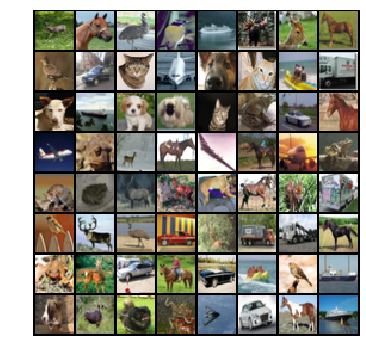

In [8]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print("images shape: {} | labels shape: {}".format(images.shape, labels.shape))
img_grid = torchvision.utils.make_grid(images[:64])
imgshow(img_grid, 6, 6)

### Play with conv dimensions

In [60]:
x = torch.randn(1, 3, 112, 112)  # batches, channels, w, h

In [35]:
conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
pool1 = nn.AdaptiveMaxPool2d((56, 56))  # desired output size

# pool1 = nn.MaxPool2d(2)

conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
pool2 = nn.AdaptiveMaxPool2d((28, 28))

conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
pool3 = nn.AdaptiveAvgPool2d((14, 14))

fc1 = nn.Linear(in_features=64 * 14 * 15, out_features=1024)
fc2 = nn.Linear(in_features=1024, out_features=6)

Linear(in_features=13440, out_features=1024, bias=True)

In [29]:
convolved1 = conv1(x)
convolved1.shape

torch.Size([1, 16, 112, 112])

In [30]:
pooled1 = pool1(convolved1)
pooled1.shape

torch.Size([1, 16, 56, 56])

In [31]:
convolved2 = conv2(pooled1)
convolved2.shape

torch.Size([1, 32, 56, 56])

In [32]:
pooled2 = pool2(convolved2)
pooled2.shape

torch.Size([1, 32, 28, 28])

In [34]:
convolved3 = conv3(pooled2)
convolved3.shape

torch.Size([1, 64, 28, 28])

In [33]:
nn.Linear()

TypeError: __init__() missing 2 required positional arguments: 'in_features' and 'out_features'

### Net Implementaton

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)),
            ("relu1", nn.ReLU(inplace=True)),
            ("pool1", nn.AdaptiveMaxPool2d(output_size=(16, 16))),  # 8x8
            ("conv2", nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)),
            ("relu2", nn.ReLU(inplace=True)),
            ("pool2", nn.AdaptiveMaxPool2d(output_size=(4, 4)))  # 4x4
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ("fc1", nn.Linear(in_features=64 * 4 * 4, out_features=128)),
            ("relu_fc", nn.ReLU(inplace=True)),
            ("fc2", nn.Linear(in_features=128, out_features=10))
        ]))

    def forward(self, x, return_probs=False):
        x = self.layers(x)
        x = x.view(x.size(0), 64 * 4 * 4)
        x = self.fc(x)
        if return_probs:
            x = F.softmax(x, dim=1)
        return x
    
    @classmethod
    def get_model_from_path(cls, model_path):
        net = cls()
        net.load_state_dict(torch.load(model_path))
        net.eval()
        net = net.to(device)
        return net

In [4]:
def train_net(train, test, net, lr, epochs=10):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    cross_entropy = nn.CrossEntropyLoss()
    losses_train, losses_test = [], []
    for epoch in range(epochs):

        for b_id, batch in enumerate(train):
            optimizer.zero_grad()

            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = net(x_batch)
            loss_var = cross_entropy(logits, y_batch)
            loss_var.backward()
            optimizer.step()

            loss_train_batch = loss_var.item()
            losses_train.append(loss_train_batch)
            
            test_loss = -1 # apply_net_test(test, net, cross_entropy)
            losses_test.append(test_loss)
            
            acc_train_batch = accuracy_from_logits(logits, y_batch)
            del loss_var 
            
        print("[{:3d}ep {:2d}bch] - train_loss:{:2.3f}| acc:{:2.2f} || test_loss:{:2.3f}".format(epoch, b_id, loss_train_batch, acc_train_batch, test_loss))


    return losses_train, losses_test

def apply_net_test(test, net, cross_entropy):
    losses = []
    for x, y in test:
        x, y = x.to(device), y.to(device)
        logits = net(x)
        loss_var = cross_entropy(logits, y)
        loss = loss_var.item()
        losses.append(loss)
        del loss_var
        # accu = accuracy_from_logits(logits, y)
    return np.mean(loss)

def accuracy_from_logits(predicted_logits, y_true):
    y_predicted = predicted_logits.argmax(dim=1)
    accuracy = accuracy_score(y_true.cpu(), y_predicted.cpu())
    return accuracy

### Net Training

In [57]:
net = ConvNet()
net.to(device)
summary(net, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
 AdaptiveMaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
              ReLU-5           [-1, 64, 16, 16]               0
 AdaptiveMaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 128]         131,200
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 171,210
Trainable params: 171,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 4.38
Params size (MB): 0.65
Estimated Total Size (MB): 5.08
-------------------------------------------

In [40]:
losses_train, losses_test = [], []

In [62]:
net = net.train()

lr = .1
epochs = 16
losses_train_, losses_test_ =  train_net(trainloader, testloader, net, lr, epochs=epochs)
losses_train.extend(losses_train_)

[  0ep 49bch] - train_loss:2.153| acc:0.26 || test_loss:-1.000
[  1ep 49bch] - train_loss:2.053| acc:0.26 || test_loss:-1.000


KeyboardInterrupt: 

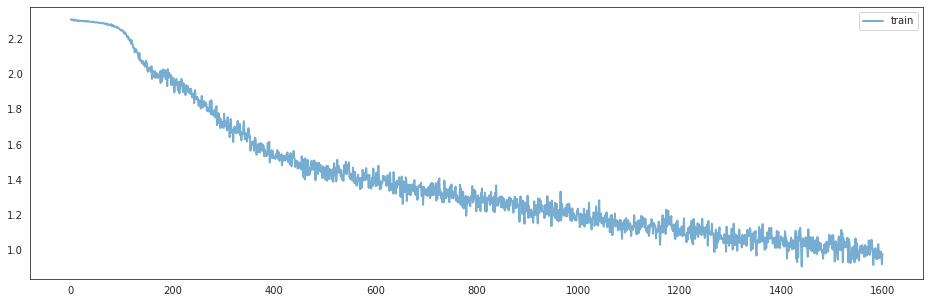

In [56]:
plt.plot(losses_train, ls="-", lw=2, alpha=.6, label="train")
# plt.plot(losses_test, ls="--", lw=2, alpha=.6, label="validation")
f = plt.gcf()
f.set_size_inches((16, 5))
plt.legend()

In [42]:
# torch.save(net.state_dict(), model_path)

### Evaluation

In [9]:
def predict_url(model, url, classes=CLASSES):
    # get image
    image = io.imread(url)
    image = cv2.resize(image, (64, 64), cv2.INTER_CUBIC)
    # prepare input to net
    tensor = torch.tensor(image.transpose((2, 0, 1)).reshape((1, 3, 64, 64))).float()
    tensor /= 255
    tensor = tensor.to(device)
    # predict
    pred_logits = net.forward(tensor)
    pred_prob = F.softmax(pred_logits, dim=1)
    pred_prob = pred_prob.data.cpu().numpy().flatten()
    # plot
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(image)
    axs[1].barh(classes, pred_prob)
    axs[1].set_xlim((0, 1))
    fig.set_size_inches((5, 1.75))

In [7]:
net = ConvNet.get_model_from_path(model_path)

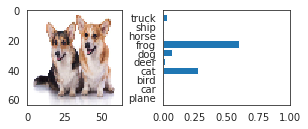

In [10]:
url = "https://ip.index.hr/remote/indexnew.s3.index.hr/images2/corgi12.jpg?width=765&height=528"
predict_url(net, url)

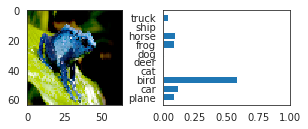

In [96]:
url = "https://kids.sandiegozoo.org/sites/default/files/2017-06/animal-hero-poisonfrog_1.jpg"
predict_url(net, url)

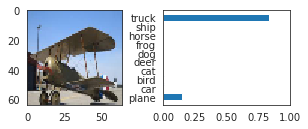

In [55]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8SvFRWgs6vypCW-AsBK-4zKv6U1_J1RoFnN4rAMHWmdDV-Lfh"
predict_url(net, url)

In [96]:
models = []
class NetsEvaluator:
    def __init__(self, test_data: torch.utils.data.DataLoader, models: List[nn.Module]):
        self.models = models
        [m.eval() for m in self.models]
        self.test_data = test_data
        self.predicted_probs = [list() for x in range(len(models))]  # [modelA_logits, modelB_logits, ..,]
        self.y = test_data.dataset.targets
        self.stats_dict = OrderedDict()
        
    def run_evaluation(self):
        self.calculate_predictions()
        self.calculate_stats()
        print(self.stats_dict)
        self.compare_models()
        self.show_errors()
        
    def calculate_predictions(self):
        num_batches = len(self.test_data)
        for bid, (x_batch, y_batch) in enumerate(self.test_data):
            print("Calculate predictions: batch [{:2d} / {:2d}]".format(bid+1, num_batches))
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            for model_id, model in enumerate(self.models):
                with torch.no_grad():
                    pred_batch = model.forward(x_batch, return_probs=True)
                    self.predicted_probs[model_id].extend(pred_batch.cpu())
        # concat to one tensor per model
        self.predicted_probs = [torch.stack(p) for p in self.predicted_probs]
            
    def calculate_stats(self):
        # calculate accuracy
        acc_vals = []
        for model_id, model in enumerate(self.models):
            predicted_probs = self.predicted_probs[model_id]
            predicted_class = predicted_probs.argmax(dim=1)
            model_acc = accuracy_score(self.y, predicted_class)
            acc_vals.append(model_acc)
        self.stats_dict["accuracy"] = acc_vals
    
    def compare_models(self):
        pass
    
    def show_errors(self):
        pass
    


In [97]:
evaluator = NetsEvaluator(testloader, [net])

In [98]:
evaluator.calculate_predictions()

Calculate predictions: batch [ 1 / 10]
Calculate predictions: batch [ 2 / 10]
Calculate predictions: batch [ 3 / 10]
Calculate predictions: batch [ 4 / 10]
Calculate predictions: batch [ 5 / 10]
Calculate predictions: batch [ 6 / 10]
Calculate predictions: batch [ 7 / 10]
Calculate predictions: batch [ 8 / 10]
Calculate predictions: batch [ 9 / 10]
Calculate predictions: batch [10 / 10]


In [99]:
evaluator.calculate_stats()

In [100]:
evaluator.stats_dict

OrderedDict([('accuracy', [0.6386])])

### Visualization

In [117]:
params = list(net.parameters())
params_l = []
for i,p in enumerate(params):
    
    print(p.shape)
    params_l.append(p.detach().cpu())

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 1024])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [127]:
params_l[0].shape

torch.Size([64, 3, 3, 3])

In [122]:
kernels = net.extractor[0].weight.detach().clone()

AttributeError: 'ConvNet' object has no attribute 'extractor'

In [164]:
layer1 = torchvision.utils.make_grid(params_l[0], normalize=True, padding=1, pad_value=1, scale_each=False)
# layer1[layer1==0.0] = 1.0

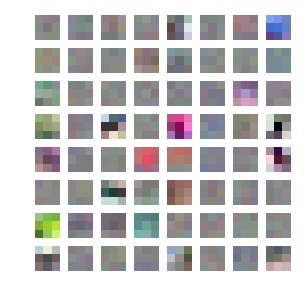

In [179]:
imgshow(layer1, 5, 5)

In [62]:
import torch.onnx

    dummy_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(net, dummy_input, "my_net.onnx")

In [52]:
!pip install torchsummary

In [181]:
alnet = torchvision.models.alexnet(pretrained=True)

In [182]:
summary(alnet, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [184]:
alnet_params = alnet.parameters()
alnet_l1 = next(alnet_params).detach().cpu()

alnet_l1.shape

torch.Size([64, 3, 11, 11])

In [190]:
# alnet_l1 = alnet_l1 - alnet_l1.min()
# alnet_l1 = alnet_l1 / alnet_l1.max()
alnet_l1_grid = torchvision.utils.make_grid(alnet_l1, padding=1, pad_value=1, normalize=True, scale_each=True)

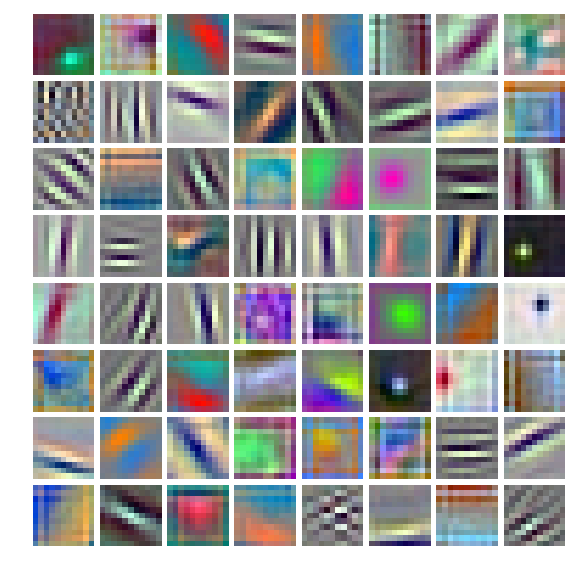

In [191]:
imgshow(alnet_l1_grid, 10, 10)

In [31]:
torch.__version__

'1.1.0'

In [37]:
net.state_dict()

OrderedDict([('layers.conv1.weight', tensor([[[[ 0.0853,  0.0619,  0.0284],
                        [-0.0922, -0.1935,  0.0083],
                        [ 0.0278, -0.1139, -0.0996]],
              
                       [[ 0.0212, -0.1937, -0.2107],
                        [ 0.0313, -0.2599,  0.0373],
                        [ 0.0387,  0.1037,  0.0914]],
              
                       [[-0.1667,  0.0828, -0.0318],
                        [ 0.0324, -0.1762, -0.1551],
                        [ 0.0735, -0.2811, -0.1166]]],
              
              
                      [[[ 0.0207, -0.3044, -0.3166],
                        [-0.1450, -0.2414, -0.1948],
                        [ 0.0761, -0.1308, -0.0947]],
              
                       [[-0.0579,  0.0430, -0.1396],
                        [ 0.0387,  0.0456,  0.0902],
                        [-0.1574, -0.2764, -0.2718]],
              
                       [[ 0.0611, -0.2174, -0.1412],
                        [ 0.1837,

In [75]:
x = x.to(device)
batch_pred = net.forward(x)

In [78]:
batch_pred.shape

torch.Size([1000, 10])

In [81]:
sp = F.softmax(batch_pred, dim=1)